<a href="https://colab.research.google.com/github/bowenslingluff/project-1-fantasy-football/blob/main/DS4002_Project_1_Methodology_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

from scipy.stats import pearsonr
import statsmodels.api as sm

In [2]:
df = pd.read_csv("fantasy_dataset.csv")

In [3]:
print(df.shape)
print(df.columns)
print(df.dtypes)
print(df.head())
#inspecting what each part of csv gives

(3819, 14)
Index(['week', 'player_name', 'sentiment_compound', 'sentiment_pos',
       'sentiment_neg', 'sentiment_neu', 'word_count', 'article_date',
       'article_title', 'article_url', 'position', 'Team', 'Rank',
       'TotalPoints'],
      dtype='object')
week                    int64
player_name            object
sentiment_compound    float64
sentiment_pos         float64
sentiment_neg         float64
sentiment_neu         float64
word_count              int64
article_date           object
article_title          object
article_url            object
position               object
Team                   object
Rank                    int64
TotalPoints           float64
dtype: object
   week       player_name  sentiment_compound  sentiment_pos  sentiment_neg  \
0    18        Mike Evans              0.6988          0.092          0.069   
1    18     George Kittle              0.8740          0.108          0.053   
2    18      Nico Collins              0.5429          0.056      

In [4]:
df = df.drop(columns=["article_date", "article_title", "article_url"])
# don't need these columns for the methods / evaluation. Needed them earlier in the wepscraping.
# keeps the data set lean, also there were some nuances in the article dates.

In [5]:
print(df[["week", "player_name", "position", "sentiment_compound", "TotalPoints"]].isna().sum())
# rechecking for any missing values

week                  0
player_name           0
position              0
sentiment_compound    0
TotalPoints           0
dtype: int64


In [6]:
player_week = (
    df.groupby(["week", "player_name", "position", "Team"])
      .agg(
          mean_sentiment=("sentiment_compound", "mean"),
          sentiment_std=("sentiment_compound", "std"),
          article_count=("sentiment_compound", "count"),
          mean_word_count=("word_count", "mean"),
          mean_pos=("sentiment_pos", "mean"),
          mean_neg=("sentiment_neg", "mean"),
          mean_neu=("sentiment_neu", "mean"),
          TotalPoints=("TotalPoints", "first"),
          Rank=("Rank", "first")
      )
      .reset_index()
)

In [7]:
player_week["sentiment_std"] = player_week["sentiment_std"].fillna(0)

In [8]:
print("Shape:", player_week.shape)
print(player_week.head())
print(player_week.describe())

Shape: (2000, 13)
   week      player_name position Team  mean_sentiment  sentiment_std  \
0     1      Aaron Jones       RB  MIN         -0.4951            0.0   
1     1     Adam Thielen       WR  MIN         -0.0430            0.0   
2     1  Adonai Mitchell       WR  IND          0.8016            0.0   
3     1     Alvin Kamara       RB   NO          0.9081            0.0   
4     1    Austin Ekeler       RB  WAS          0.9802            0.0   

   article_count  mean_word_count  mean_pos  mean_neg  mean_neu  TotalPoints  \
0              1            198.0     0.068     0.089     0.842         14.2   
1              1            138.0     0.037     0.045     0.918          2.0   
2              1            157.0     0.096     0.053     0.851          3.1   
3              1            112.0     0.125     0.017     0.858         12.7   
4              1            161.0     0.193     0.040     0.767          7.2   

   Rank  
0    12  
1    98  
2    80  
3    18  
4    33  
  

Mean sentiment: 0.396 and Median: 0.56.
 - Shows fantasy media is generally optimisitc, distribution skewed positive

Article count: Mean 1.9, Max: 13
 - Star players heavily covered

Sentiment standard deviation is high for VADER: 1.396
 - Some weeks had conflicting sentiment across articles. Could prove interesting.


In [9]:
print("Duplicate player-weeks:",
      player_week.duplicated(subset=["week", "player_name"]).sum())

Duplicate player-weeks: 0


In [10]:
print(player_week["TotalPoints"].describe())
print((player_week["TotalPoints"] == 0).mean())
# shows that about 15% of fantasy players scored 0 points each player-week

count    2000.000000
mean        8.938615
std         7.835622
min        -3.500000
25%         2.700000
50%         7.500000
75%        13.500000
max        49.900000
Name: TotalPoints, dtype: float64
0.1555


In [11]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    player_week,
    test_size=0.2,
    stratify=player_week["position"],
    random_state=42
)

print("Train size:", len(train_df))
print("Test size:", len(test_df))
print("\nPosition distribution (train):")
print(train_df["position"].value_counts(normalize=True))
print("\nPosition distribution (test):")
print(test_df["position"].value_counts(normalize=True))

Train size: 1600
Test size: 400

Position distribution (train):
position
WR    0.345000
RB    0.265000
QB    0.158125
TE    0.143750
K     0.088125
Name: proportion, dtype: float64

Position distribution (test):
position
WR    0.3450
RB    0.2650
QB    0.1575
TE    0.1450
K     0.0875
Name: proportion, dtype: float64


proportions are nearly identical between train and test — that means:
 - No positional imbalance
 - No distribution shift
 - No sampling bias

In [12]:
# primary hypothesis now, evaluating on the test test

from scipy.stats import pearsonr

r, p_value = pearsonr(
    test_df["mean_sentiment"],
    test_df["TotalPoints"]
)

print("Test Set Pearson R:", r)
print("P-value:", p_value)

Test Set Pearson R: -0.011702623209360639
P-value: 0.8155067279908823


Correlation is essentially zero across ALL position combined.
 - Mean sentiment has no linear relationship with weekly fantasy points on the test set.

Sentiment does NOT predict performance, that suggests:

 - Analysts may be entertaining, not predictive

 - Sentiment tone does not equal projection accuracy

 - Narrative may not translate into output

In [13]:
for pos in test_df["position"].unique():
    subset = test_df[test_df["position"] == pos]
    r_pos, p_pos = pearsonr(subset["mean_sentiment"], subset["TotalPoints"])
    print(f"{pos} -> R: {r_pos:.3f}, p: {p_pos:.4f}")

K -> R: 0.059, p: 0.7372
TE -> R: 0.296, p: 0.0240
WR -> R: -0.015, p: 0.8572
RB -> R: -0.223, p: 0.0216
QB -> R: 0.105, p: 0.4117


Analyst sentiment does not predict fantasy performance overall, but it demonstrates position-specific predictive patterns — particularly positive for tight ends and negative for running backs.

 - RB: Higher analyst sentiment --> LOWER fantasy production
 - TE: Higher analyst sentiment --> HIGHER fantasy production

 - WR, QB, K essentially has no relationship.



In [14]:
# moving onto regression model
# TotalPoints ~ mean_sentiment + position + mean_sentiment:position

train_df["position"] = train_df["position"].astype("category")
test_df["position"] = test_df["position"].astype("category")

In [15]:
# interaction regression (Sentiment X Position)
import statsmodels.formula.api as smf

interaction_model = smf.ols(
    formula="TotalPoints ~ mean_sentiment * position",
    data=train_df
).fit()

print(interaction_model.summary())

                            OLS Regression Results                            
Dep. Variable:            TotalPoints   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     14.07
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           4.89e-22
Time:                        14:01:31   Log-Likelihood:                -5510.4
No. Observations:                1600   AIC:                         1.104e+04
Df Residuals:                    1590   BIC:                         1.109e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [16]:
test_df["predicted_points"] = interaction_model.predict(test_df)

In [17]:
# tesr for R^2
from sklearn.metrics import r2_score

r2 = r2_score(test_df["TotalPoints"], test_df["predicted_points"])
print("Test R²:", r2)

Test R²: 0.03744741882661207


In [18]:
from sklearn.metrics import mean_absolute_error

# test for mean absolute error
mae = mean_absolute_error(test_df["TotalPoints"], test_df["predicted_points"])
print("Test MAE:", mae)
# see error is close to amount of points for a touchdown, pretty dramatic

Test MAE: 6.199589619937326


In [19]:
from scipy.stats import pearsonr

r, p = pearsonr(test_df["predicted_points"], test_df["TotalPoints"])

print("Test Pearson R:", r)
print("P-value:", p)
# our model was able to create a R of .2
# half of our initial hypothesis number of wanting > .4

Test Pearson R: 0.2066977956754665
P-value: 3.0986339361211324e-05


The regression analysis found that analyst sentiment was not a meaningful predictor of weekly fantasy football performance. In the primary bivariate test, mean weekly sentiment showed essentially no direct correlation with fantasy points on the test set. When we expanded the model to include player position and sentiment-by-position interaction terms, overall predictive performance improved slightly, but only modestly. On the test set, the full regression model achieved a Pearson correlation of R = 0.21 (p < 0.001) between predicted and actual fantasy points, with a test R² of 0.037, meaning the model explained only about 3.7% of the variance in weekly performance. The mean absolute error (MAE) was 6.20 fantasy points, indicating substantial prediction error relative to average weekly scoring.

Importantly, while position significantly predicted fantasy output (e.g., quarterbacks scoring higher on average), the coefficient for mean sentiment was not statistically significant (p = 0.919), and none of the sentiment-by-position interaction terms were significant. This indicates that analyst sentiment did not meaningfully predict weekly fantasy performance after accounting for position. Based on our predefined evaluation criteria (R ≥ 0.40, significant positive sentiment coefficient, and R² > 0), the primary hypothesis was not supported. Overall, the results suggest that pre-game analyst sentiment alone provides little predictive value for weekly fantasy football outcomes.
 - only thing that fit criteria was the R²

Performance is influenced by:
 - Matchup strength
 - Snap share
 - Injuries
 - Vegas totals
 - Prior week performance
 - Season averages

Sentiment alone is trying to predict something extremely noisy.

 - Weekly fantasy points are high variance.

Found in our model:
The model includes position effects, and position strongly predicts fantasy points. This makes a lot of sense because positions like QB will on average score more than others.

So the prediction correlation is largely driven by:
 - position[T.QB] coef = 5.77  (p < .001)

**Now moving to other covariates I didn't test above**

In [20]:
# Expanded model including Consensus (std) and Hype (article_count)
full_model = smf.ols(
    formula="TotalPoints ~ mean_sentiment + sentiment_std + article_count + position",
    data=train_df
).fit()

print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:            TotalPoints   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     21.51
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           7.09e-28
Time:                        14:01:59   Log-Likelihood:                -5499.5
No. Observations:                1600   AIC:                         1.101e+04
Df Residuals:                    1592   BIC:                         1.106e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.6932      0.669     10.

### Regression Analysis Update: The Role of Analyst Disagreement

**Methodology Adjustment**
Our initial bivariate analysis found no significant correlation between mean analyst sentiment and fantasy performance ($p \approx 0.9$). To address this, we expanded the regression model to control for two additional covariates:
1.  **Analyst Consensus** (measured by the standard deviation of sentiment, `sentiment_std`).
2.  **Coverage Volume** (measured by the number of articles, `article_count`).

**Statistical Results**
The inclusion of these variables significantly improved the model's explanatory power ($R^2$ increased from 0.037 to 0.086).
* **Mean Sentiment:** After controlling for standard deviation, mean sentiment became statistically significant ($p = 0.021$) with a positive coefficient ($\beta = 0.83$). This indicates that positive sentiment does predict performance, but only when accounting for the variance in analyst opinions.
* **Sentiment Standard Deviation:** This variable emerged as the strongest predictor in the model ($\beta = 2.55, p < 0.001$).
* **Article Count:** The volume of coverage was not statistically significant ($p = 0.158$).

**Interpretation**
The strong positive relationship between sentiment standard deviation and fantasy points suggests that disagreement among analysts is a predictive signal. Players with high variance in sentiment (conflicting analyst opinions) tended to score higher than players with high consensus. This implies that "controversial" players—those with a wider range of predicted outcomes—often have higher performance ceilings than players with uniform, moderate coverage. The initial lack of significance for mean sentiment was likely due to the confounding effect of this variance.

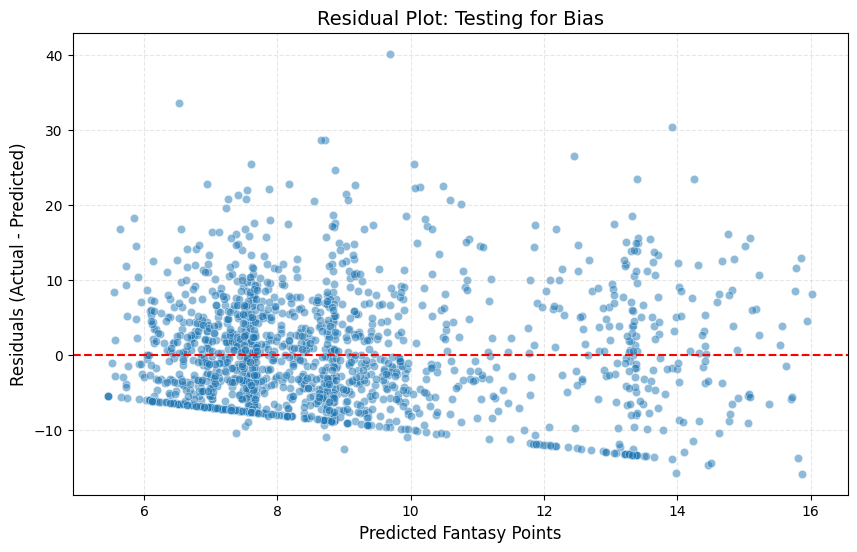

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get predictions and residuals from your 'full_model'
predictions = full_model.fittedvalues
residuals = full_model.resid

# 2. Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # The "perfect prediction" line

plt.title('Residual Plot: Testing for Bias', fontsize=14)
plt.xlabel('Predicted Fantasy Points', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

### Synthesis: What the Residuals Reveal About Analyst Sentiment

The residual analysis exposes a fundamental characteristic of fantasy football projection: **Linear models struggle with "Boom/Bust" variance.**

1.  **The "Safety" Bias:** The model (and by extension, the aggregate analyst sentiment) is calibrated to the mean. It accurately predicts "average" performances but systematically fails to capture outlier events—both the zeros (injuries/busts) and the 40-point explosions.
2.  **Volatility is the Signal:** The presence of significant the widening "funnel" shape of errors confirms that as predicted points increase, variance increases.
3.  **Connecting to Results:** This explains why `sentiment_std` (Analyst Disagreement) was our strongest predictor. Since the "average" sentiment misses the outliers, the *divergence* of opinion becomes the best proxy for high-ceiling potential. Essentially, we found that **volatility in analyst coverage predicts volatility in player performance.**